## Image identification using fwrf gabor models, 2014 imagery.rf data



In [2]:
import numpy as np
import pandas as pd
import h5py
import nibabel as nib
import matplotlib.pyplot as plt
import pickle
from glob import glob
from PIL import Image
from imagery_rf_field.src.glmd_betas import *
from os.path import join
from time import time
from glob import glob
from scipy.io import loadmat
from scipy.stats import pearsonr, rankdata
from hrf_fitting.src.feature_weighted_rf_models import make_rf_table,receptive_fields, model_space, prediction_menu, bigmult
from hrf_fitting.src.feature_weighted_rf_models import leave_k_out_training, split_em_up
from hrf_fitting.src.gabor_feature_dictionaries import gabor_feature_maps
from math import atan2, degrees
from IPython.display import Image as ipyImage

Using gpu device 0: GeForce GTX TITAN X


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
#load the models
#load the betas
#load the stimuli
#select voxels for img using pcp pred. scores, vice versa
#generate predictions
#240 x 240 correlation matrices grouped by 

### 0. load the models

In [5]:
##must first redefine the activation function to the namespace or pickle annoyingly wont work
def log_act_func(x):
    return np.log(1+np.sqrt(x))


In [6]:

state_list = ['pcp', 'img']
saving_place = '/media/tnaselar/Data/imagery_rf.2014/model_runs/'
ms={}
for ii,state in enumerate(['pcp','img']):
    saving_file = 'model_space_'+'fwrf_gabor_robust_'+state+'_'+'TN'+'.p'
    ms[state]=pickle.load(open( join(saving_place, saving_file), "r"))

val_cc = {}    
val_cc['pcp'] = ms['pcp'].val_cc

val_cc['img'] = ms['img'].val_cc

### 1. load the data

In [7]:
saving_spot = '/media/tnaselar/Data/scratch/'

####with z-score
# beta_path = '/musc.repo/Data/jesse/imagery_RF/brainthresh99_0_05_with_Zscore/betas/'
# file_exp = '%s_all_runs_BETAs_w_zscore.mat'

####withOUT z-score
beta_path = '/musc.repo/Data/jesse/imagery_RF/brainthresh99_0_05_withOUT_Zscore/betas/'
file_exp = '%s_all_runs_BETAs_no_zs.mat'
subject = 'TN'
stim_loc = '/musc.repo/mri/7T.cmrr/Presentation/imagery.rf.7T.July.2014/'
cond_file_path = '/musc.repo/Data/jesse/imagery_RF/brainthresh99_0_05_withOUT_Zscore/condit_names/%s_condit_names.mat' %(subject)
mask_path = '/media/tnaselar/Data/imagery_rf.2014/masks/%s_mask.nii.gz' %(subject)
print '==============+++++++++========SUBJECT: %s' %(subject)
beta_df = load_betas_from_mat_file(join(beta_path,file_exp) %(subject))
mask = load_mask_from_nii(mask_path)
stim_df = load_stim_from_mat_file(cond_file_path,stim_loc)
fMRI = imagery_rf_dataset(subject, beta_df, stim_df, mask)

==============+++++++++========SUBJECT: TN


In [8]:
##reconstitute the validation sets
idx = {}
idx['img'] = fMRI.get_stimuli_with('run','img').index
idx['pcp'] = fMRI.get_stimuli_with('run','pcp').index


print 'number of imagery stimuli: %d' %(len(idx['img']))
print 'number of perception stimuli: %d' %(len(idx['pcp']))

val_frac = 0.04687
n_resamples = 10
val_idx = {}
for state in state_list:
    val_idx[state] = split_em_up(len(idx[state]),val_frac,n_resamples)

number of imagery stimuli: 512
number of perception stimuli: 512
number of validation samples: 24
number of validation samples: 24


In [9]:

for state in state_list:
    for ii in range(n_resamples):
        print len(fMRI.stim.loc[np.array(idx[state])[val_idx[state][ii]],'location'].unique())
        print fMRI.stim.loc[np.array(idx[state])[val_idx[state][ii]],'run'].unique()

8
[u'1pcp' u'2pcp' u'3pcp' u'4pcp']
8
[u'1pcp' u'2pcp' u'3pcp' u'4pcp']
7
[u'1pcp' u'2pcp' u'3pcp' u'4pcp']
8
[u'1pcp' u'2pcp' u'3pcp' u'4pcp']
7
[u'1pcp' u'2pcp' u'3pcp' u'4pcp']
7
[u'1pcp' u'2pcp' u'3pcp' u'4pcp']
7
[u'1pcp' u'2pcp' u'3pcp' u'4pcp']
8
[u'1pcp' u'2pcp' u'3pcp' u'4pcp']
8
[u'1pcp' u'2pcp' u'3pcp' u'4pcp']
8
[u'1pcp' u'2pcp' u'3pcp' u'4pcp']
8
[u'1img' u'2img' u'3img' u'4img']
8
[u'1img' u'2img' u'3img' u'4img']
7
[u'1img' u'2img' u'3img' u'4img']
8
[u'1img' u'2img' u'3img' u'4img']
7
[u'1img' u'2img' u'3img' u'4img']
7
[u'1img' u'2img' u'3img' u'4img']
7
[u'1img' u'2img' u'3img' u'4img']
8
[u'1img' u'2img' u'3img' u'4img']
8
[u'1img' u'2img' u'3img' u'4img']
8
[u'1img' u'2img' u'3img' u'4img']


In [10]:
### 2. load the stimuli

In [11]:
##load the stimuli
max_feature_res = np.max(ms['pcp'].feature_resolutions.values())

load_stim_func = lambda dx: np.array(fMRI.get_condition_stimuli(dx,output = 'PIL',image_size=(max_feature_res,max_feature_res)).convert('L'))[np.newaxis,np.newaxis] 

stimuli = {}
total_val_idx = {}
for state in state_list:
    total_val_idx[state] = np.array(idx[state])[np.concatenate(val_idx[state].values()).astype('int')]
    stimuli[state] = np.concatenate(map(load_stim_func,
                                        total_val_idx[state]),
                                    axis=0)


### 2. reconstitute the gabors

In [12]:
native_stim_size = 600  ##pixels
viewing_distance = 100 ##cm
viewing_area = 38.8 ##cm

# Calculate the number of degrees that correspond to a single pixel. This will
# generally be a very small value, something like 0.03.
deg_per_px = degrees(atan2(.5*viewing_area, viewing_distance)) / (.5*native_stim_size)
print '%f pixels correspond to one degree' % (1./deg_per_px)
# Calculate the size of the stimulus in degrees
size_in_deg = native_stim_size * deg_per_px
print 'The size of the stimulus is %s pixels and %s visual degrees' % (native_stim_size, size_in_deg)
n_orientations = 4
deg_per_stimulus = 21.958
lowest_sp_freq = .114 ##cyc/deg
highest_sp_freq = 4.5
num_sp_freq = 8
pix_per_cycle = 4.#2.13333333
complex_cell = True
n_colors = 1 ##let's do grayscale first
diams_per_filter = 4
cycles_per_radius = 2.0

print 'D = total number of features = %d' %(n_orientations * num_sp_freq)
gfm = gabor_feature_maps(n_orientations,
                         deg_per_stimulus,
                         (lowest_sp_freq,highest_sp_freq,num_sp_freq),
                         pix_per_cycle=pix_per_cycle,complex_cell=complex_cell,
                         diams_per_filter = diams_per_filter,
                         cycles_per_radius = cycles_per_radius,
                         color_channels=n_colors)
gfm.gbr_table.head(9)

27.324889 pixels correspond to one degree
The size of the stimulus is 600 pixels and 21.958003465 visual degrees
D = total number of features = 32


,cycles per deg.,cycles_per_filter,filter size (deg.),pix per stimulus,pix_per_filter,radius of Gauss. envelope (deg),orientation
0,0.114000,16,140.350877,10.012848,64,17.543860,0.000000
1,0.192730,16,83.017792,16.927841,64,10.377224,0.000000
2,0.325831,16,49.105171,28.618412,64,6.138146,0.000000
3,0.550854,16,29.045796,48.382631,64,3.630724,0.000000
4,0.931281,16,17.180639,81.796257,64,2.147580,0.000000
5,1.574435,16,10.162379,138.285735,64,1.270297,0.000000
6,2.661758,16,6.011065,233.787525,64,0.751383,0.000000
7,4.500000,16,3.555556,395.244000,64,0.444444,0.000000
8,0.114000,16,140.350877,10.012848,64,17.543860,0.785398


### 3. select the voxels 

In [41]:
count_thresh = 0.25
vox_idx = {}
vox_idx['img'] = np.where(map(lambda x: x > count_thresh, val_cc['pcp']))[0]
vox_idx['pcp'] = np.where(map(lambda x: x > count_thresh, val_cc['img']))[0]

nvox = {}
for state in state_list:
    nvox[state] = len(vox_idx[state])
    print 'number of voxels %d' %(nvox[state])



number of voxels 1212
number of voxels 9384


### 4. predictions

In [42]:
pred = {}
corr_matrix = {}
mst = {}
for state in state_list: #[pcp', 'img']:
    print '==========================================================%s' %(state)
    ##build feature diction. overwrite across state
    feature_dict = gfm.create_feature_maps(stimuli[state])
    ##build model space tensor
    mst[state] = ms[state].construct_model_space_tensor(feature_dict, normalize=False)
    mst[state] = ms[state].normalize_model_space_tensor(mst[state],save=True)

    voxel_data = fMRI.betas[vox_idx[state],:][:,total_val_idx[state]].T ##stim x vox
    print 'voxel dims: %s' %(voxel_data.shape,)
    
    ##generate predictions
    Tval = len(val_idx[state][0])
    pred[state] = np.zeros((Tval*n_resamples,nvox[state]))  ##stim x vox
    corr_matrix[state] = np.zeros((Tval*n_resamples,Tval*n_resamples))

    for val_iter in val_idx[state].keys():
        frf = ms[state].params[val_iter]['frf']
        ffw = ms[state].params[val_iter]['ffw']

        
        for ii,v in enumerate(vox_idx[state]):
            rng = slice((val_iter*Tval),(val_iter*Tval+Tval))
            pred[state][rng,ii] = np.squeeze(bigmult(mst[state][np.newaxis,frf[v],rng,:],
                                           ffw[np.newaxis,:,v, np.newaxis]))

    for c1 in range(Tval*n_resamples):
        for c2 in range(Tval*n_resamples):
            corr_matrix[state][c1, c2] = pearsonr(voxel_data[c1, :], pred[state][c2, :])[0]
        
        
        

==========================================================pcp
allocating memory for feature maps
constructing feature maps
feature 0 took 0.104261 s.
feature 1 took 0.239800 s.
feature 2 took 0.609431 s.
feature 3 took 1.152960 s.
feature 4 took 2.374282 s.
feature 5 took 5.070005 s.
feature 6 took 12.514025 s.
feature 7 took 34.535162 s.
feature 8 took 0.092127 s.
feature 9 took 0.179449 s.
feature 10 took 0.435507 s.
feature 11 took 0.860005 s.
feature 12 took 1.746001 s.
feature 13 took 3.926224 s.
feature 14 took 10.569073 s.
feature 15 took 34.811249 s.
feature 16 took 0.104084 s.
feature 17 took 0.256045 s.
feature 18 took 0.576420 s.
feature 19 took 1.106766 s.
feature 20 took 2.329746 s.
feature 21 took 4.811280 s.
feature 22 took 12.150651 s.
feature 23 took 34.851543 s.
feature 24 took 0.076878 s.
feature 25 took 0.099477 s.
feature 26 took 0.428618 s.
feature 27 took 0.855266 s.
feature 28 took 1.755849 s.
feature 29 took 3.804825 s.
feature 30 took 10.202028 s.
feature 31 t

KeyboardInterrupt: 

### 5. image id

organize trials according to location

In [43]:
loc_dict = fMRI.stim.loc[total_val_idx['pcp'],:].groupby('location').indices
clock = ['east', 'southeast', 'south', 'southwest', 'west', 'northwest', 'north', 'northeast']
loc_orders = np.concatenate([loc_dict[x] for x in clock])

image id matrix organized by location

hit rate pcp: 9
hit rate img: 1


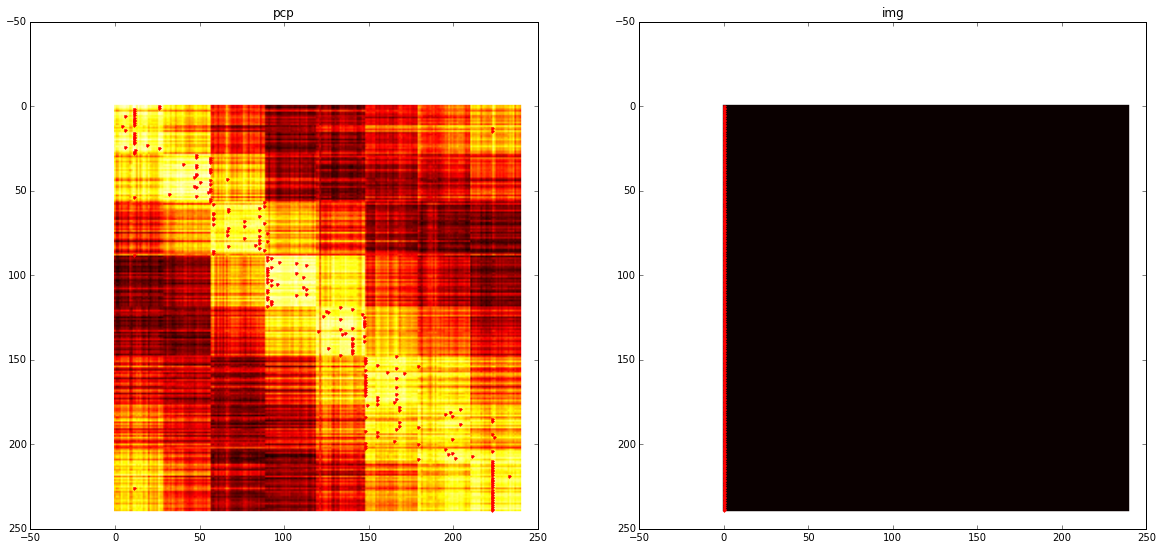

In [47]:
cnt = {}
plt.figure(figsize=(20,20))
for ii,state in enumerate(state_list):
    cnt[state] = 0
    plt.subplot(1,2,ii+1)
    cm = corr_matrix[state][loc_orders,:][:,loc_orders]
    plt.imshow(cm, cmap=plt.get_cmap('hot') )
    plt.title(state)
    for c1 in range(Tval*n_resamples):
        bst = np.argmax(cm[c1,:])
        plt.plot(bst,c1,'r.')
        if bst==c1:
            cnt[state] +=1
    print 'hit rate %s: %d' %(state, cnt[state])
# plt.colorbar()

image id matrix within-location

hit rate pcp,east: 2, 14.000000
hit rate pcp,southeast: 3, 13.000000
hit rate pcp,south: 1, 16.000000
hit rate pcp,southwest: 0, 14.000000
hit rate pcp,west: 1, 15.000000
hit rate pcp,northwest: 1, 16.000000
hit rate pcp,north: 0, 15.000000
hit rate pcp,northeast: 1, 15.000000


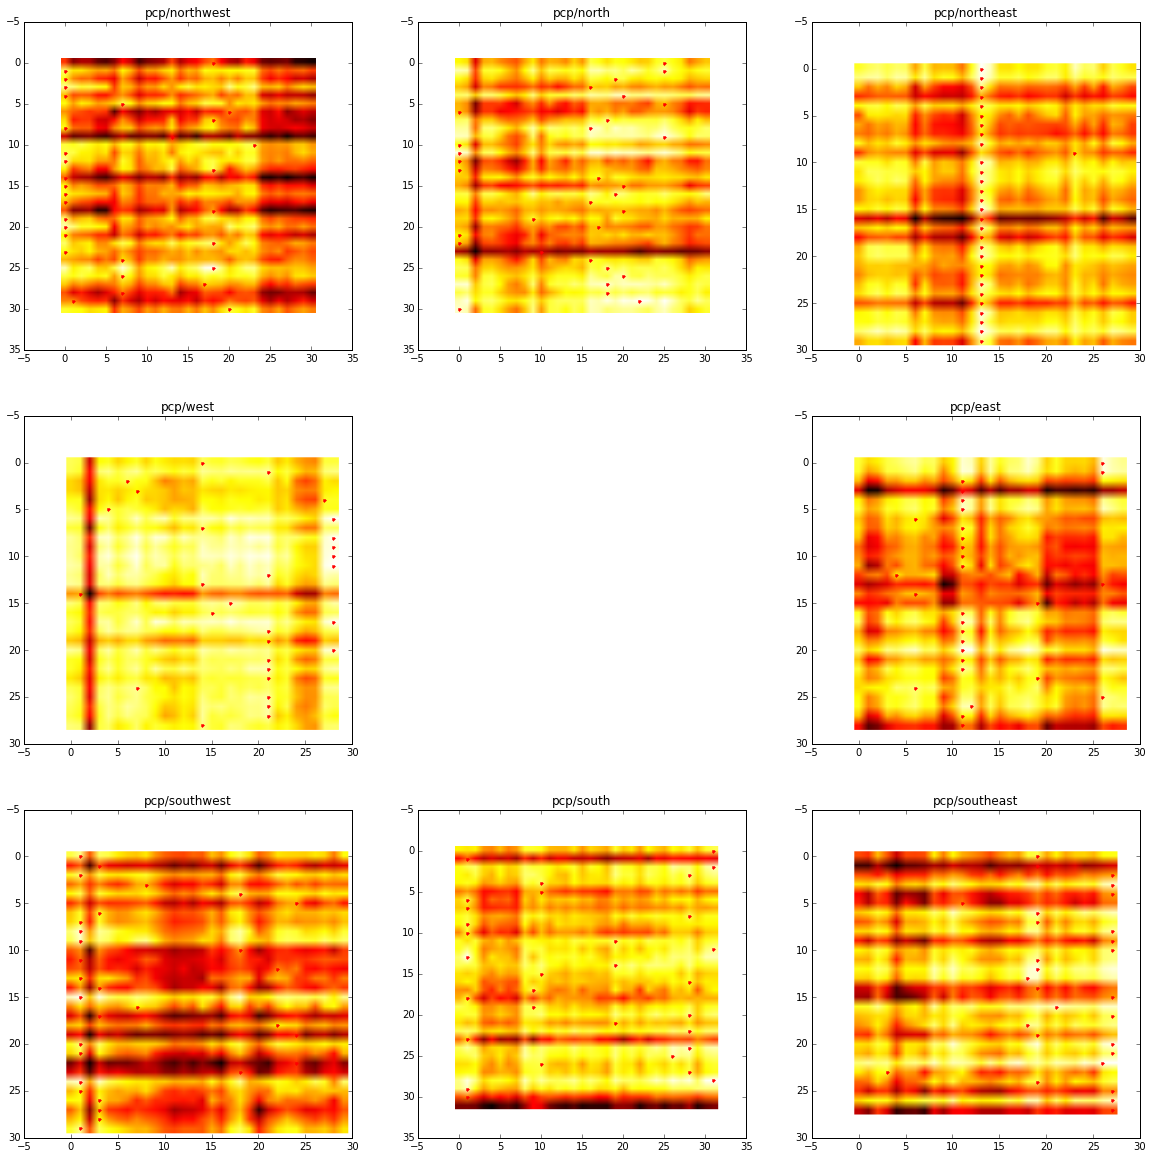

In [48]:
cnt = {}
subplot_clock = [6, 9, 8, 7, 4, 1, 2, 3]
plt.figure(figsize=(20,20))
for state in ['pcp']:
    
    for ii,loc in enumerate(clock):  
        cnt[state] = 0
        
        plt.subplot(3,3,subplot_clock[ii])
        idx = loc_dict[loc]
        cm = corr_matrix[state][idx,:][:,idx]
        plt.imshow(cm, cmap=plt.get_cmap('hot') )
        plt.title(state+'/'+loc)
        hit2 = 0
        for c1 in range(len(idx)):
            bst = np.argmax(cm[c1,:])
            plt.plot(bst,c1,'r.')
            if bst==c1:
                cnt[state] +=1
            hit2 += np.sum(cm[c1,c1] > cm[c1,:])
        print 'hit rate %s,%s: %d, %f' %(state,loc, cnt[state], hit2/len(idx))